In [5]:
"""
File that runs the actual reconstruction optimizer forward pass. 
It should compute 3 loss functions: contour chamfer loss, tip distance 
loss, and motion model loss. In its forward pass, it will call upon 
the construction_bezier and motion_catheter scripts to build its 
catheters. It will be optimizing the parameter para_init. 
"""
import sys
sys.path.append('..')
sys.path.insert(1, 'E:/OneDrive - UC San Diego/UCSD/Lab/Catheter/diff_catheter/scripts')

import torch
import torch.nn as nn
import cv2
# from tqdm.notebook import tqdm
from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt

from construction_bezier import ConstructionBezier
from loss_define import (
    ContourChamferLoss, 
    TipDistanceLoss, 
    ImageContourChamferLoss, 
    GenerateRefData
)

from catheter_motion import CatheterMotion


class ReconstructionOptimizer(nn.Module): 

    def __init__(self, p_start, para_init, image_ref, gpu_or_cpu, past_frames_list, delta_u_list, img_save_path, image_save_path_list): 
        '''
        This function initializes the catheter optimization model.

        Args:
            p_start (tensor): starting point of the catheter
            image_ref (numpy array): reference image to compare to
            gpu_or_cpu (str): either 'cuda' or 'cpu'
        '''
        super().__init__()

        self.build_bezier = ConstructionBezier(radius=0.0015)
        self.build_bezier.to(gpu_or_cpu)
        self.build_bezier.loadRawImage(img_save_path)

        self.contour_chamfer_loss = ContourChamferLoss(device=gpu_or_cpu)
        self.contour_chamfer_loss.to(gpu_or_cpu)
        self.tip_distance_loss = TipDistanceLoss(device=gpu_or_cpu)
        self.tip_distance_loss.to(gpu_or_cpu)
        self.image_contour_chamfer_loss = ImageContourChamferLoss(device=gpu_or_cpu)
        self.image_contour_chamfer_loss.to(gpu_or_cpu)
        
        # Declare self.tip_euclidean_distance_loss as a variable that'll hold a single numpy scalar value
        self.tip_euclidean_distance_loss = None
        self.tip_loss = None

        self.p_start = p_start.to(gpu_or_cpu).detach()
        self.para_init = nn.Parameter(torch.from_numpy(para_init).to(gpu_or_cpu),
                                      requires_grad=True)
        
        
        image_ref = torch.from_numpy(image_ref.astype(np.float32))
        self.register_buffer('image_ref', image_ref)
        
        # Generate reference data, so you don't need to generate it in every forward pass
        self.generate_ref_data = GenerateRefData(self.image_ref)
        ref_catheter_contour = self.generate_ref_data.get_raw_contour()
        self.register_buffer('ref_catheter_contour', ref_catheter_contour)
        ref_catheter_centerline = self.generate_ref_data.get_raw_centerline()
        self.register_buffer('ref_catheter_centerline', ref_catheter_centerline)
        
        # self.register_buffer('delta_u_list', delta_u_list)
        self.delta_u_list = delta_u_list
        # self.register_buffer('past_frames_list', past_frames_list)
        # self.register_buffer('image_save_path_list', image_save_path_list)
        self.image_save_path_list = image_save_path_list
        
        # Generate reference data for past frames
        contour_list = []
        centerline_list = []
        for image in past_frames_list:
            image = torch.from_numpy(image.astype(np.float32))
            generate_ref_data = GenerateRefData(image)
            ref_catheter_contour = generate_ref_data.get_raw_contour()
            ref_catheter_centerline = generate_ref_data.get_raw_centerline()
            contour_list.append(ref_catheter_contour)
            centerline_list.append(ref_catheter_centerline)
        # self.register_buffer('contour_list', torch.stack(contour_list))
        # self.register_buffer('centerline_list', torch.stack(centerline_list))
        self.contour_list = contour_list
        self.centerline_list = centerline_list
        
        self.gpu_or_cpu = gpu_or_cpu

    def forward(self, save_img_path): 
        '''
        Function to run forward pass of the catheter optimization model.
        Creates catheter model, gets projection onto 2d image, and calculates loss.

        Args:
            save_img_path (str): path to save the projection image to
        '''

        # print('hello')
        
        # Generate the Bezier curve cylinder mesh points
        self.build_bezier.getBezierCurveCylinder(self.p_start, self.para_init)

        # Get 2d projected Bezier Cylinder mesh points
        self.build_bezier.getCylinderMeshProjImg()

        # Get 2d projected Bezier centerline (position) points
        self.build_bezier.getBezierProjImg()

        self.build_bezier.draw2DCylinderImage(self.image_ref, save_img_path)

        loss_contour = self.contour_chamfer_loss(self.build_bezier.bezier_proj_img.to(self.gpu_or_cpu), self.ref_catheter_contour.to(self.gpu_or_cpu))

        loss_tip_distance, self.tip_euclidean_distance_loss = self.tip_distance_loss(self.build_bezier.bezier_proj_centerline_img.to(self.gpu_or_cpu), self.ref_catheter_centerline.to(self.gpu_or_cpu))
        
        p0 = self.p_start.detach().cpu().numpy()
        para_init = self.para_init.detach().cpu().numpy()
        catheterMotion = CatheterMotion(p0, r=0.0015)
        predicted_paras = catheterMotion.past_frames_prediction(self.delta_u_list, para_init)
        motion_model_loss = torch.tensor(0.0).to(self.gpu_or_cpu)
        for i in range(len(predicted_paras)):
            build_bezier = ConstructionBezier()
            build_bezier.to(self.gpu_or_cpu)
            build_bezier.loadRawImage(self.image_save_path_list[i])
            build_bezier.getBezierCurveCylinder(self.p_start, torch.from_numpy(predicted_paras[i]).to(self.gpu_or_cpu))
            build_bezier.getCylinderMeshProjImg()
            build_bezier.getBezierProjImg()
            # build_bezier.draw2DCylinderImage(self.past_frames_list[i], save_img_path_list[i])
            
            loss_contour = self.contour_chamfer_loss(build_bezier.bezier_proj_img.to(self.gpu_or_cpu), self.contour_list[i].to(self.gpu_or_cpu))
            
            # loss_tip_distance_m, self.tip_loss = self.tip_distance_loss(build_bezier.bezier_proj_centerline_img.to(self.gpu_or_cpu), self.centerline_list[i].to(self.gpu_or_cpu))
            
            motion_model_loss += loss_contour.to(self.gpu_or_cpu)
            # weight_m = torch.tensor([1.0e-4, 1.0]).to(self.gpu_or_cpu)
            # loss_m = loss_contour_m.to(self.gpu_or_cpu) * weight_m[0] + loss_tip_distance_m.to(self.gpu_or_cpu) * weight_m[1]
            # motion_model_loss += loss_m.to(self.gpu_or_cpu)
            
        
        weight = torch.tensor([1.0e-4, 1.0, 1.0e-5]).to(self.gpu_or_cpu)
        loss = loss_contour * weight[0] + loss_tip_distance * weight[1] + motion_model_loss * weight[2]


        print("-----------------------------------------------------------------")
        print("loss_contour: ", loss_contour)
        # print("loss_tip: ", loss_tip)
        # print("loss_boundary: ", loss_boundary)
        print("loss_tip_distance: ", loss_tip_distance)
        # print("loss_boundary_point_distance_loss: ", loss_boundary_point_distance_loss)
        print("motion_model_loss: ", motion_model_loss)
        print("loss: ", loss)
        print("-----------------------------------------------------------------")


        # TODO: Plot the loss

        return loss
    





In [6]:
def process_image(img_save_path):
    img_ref_rgb = cv2.imread(img_save_path)
    img_ref_gray = cv2.cvtColor(img_ref_rgb, cv2.COLOR_BGR2GRAY)
    (thresh, img_ref_thresh) = cv2.threshold(img_ref_gray, 80, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    img_ref_binary = np.where(img_ref_thresh == 255, 1, img_ref_thresh)
    
    return img_ref_binary

Model Parameters:
para_init: requires_grad=True


  0%|          | 0/100 [00:00<?, ?it/s]


loop_id:  0
-----------------------------------------------------------------
loss_contour:  tensor(22450876.4269, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(2981.3144, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(3.0979e+09, device='cuda:0')
loss:  tensor(36205.5348, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------


Optimizing:   1%|          | 1/100 [00:09<15:14,  9.24s/it, loss=3.62e+4]

Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 376819.03125
Parameter: para_init, Updated Value: tensor([ 0.0300,  0.0055,  0.0702,  0.0306, -0.0406,  0.1745], device='cuda:0')
Loss:  36205.53484186571

loop_id:  1


Optimizing:   2%|▏         | 2/100 [00:11<08:26,  5.17s/it, loss=4.28e+4]

-----------------------------------------------------------------
loss_contour:  tensor(58646667.8549, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(214.1109, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(3.6706e+09, device='cuda:0')
loss:  tensor(42784.9689, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 104923.6796875
Parameter: para_init, Updated Value: tensor([ 0.0300,  0.0055,  0.0702,  0.0330, -0.0482,  0.1685], device='cuda:0')
Loss:  42784.968902285356

loop_id:  2


Optimizing:   3%|▎         | 3/100 [00:13<06:20,  3.92s/it, loss=1.06e+5]

-----------------------------------------------------------------
loss_contour:  tensor(41098158.8712, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(1435.6228, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(1.0027e+10, device='cuda:0')
loss:  tensor(105816.2042, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 296803.78125
Parameter: para_init, Updated Value: tensor([ 0.0300,  0.0055,  0.0702,  0.0299, -0.0499,  0.1707], device='cuda:0')
Loss:  105816.20416078626

loop_id:  3


Optimizing:   4%|▍         | 4/100 [00:16<05:15,  3.28s/it, loss=2.12e+5]

-----------------------------------------------------------------
loss_contour:  tensor(7.0215e+08, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(1139.3718, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(1.4094e+10, device='cuda:0')
loss:  tensor(212294.7107, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 260567.4375
Parameter: para_init, Updated Value: tensor([ 0.0300,  0.0055,  0.0702,  0.0257, -0.0480,  0.1755], device='cuda:0')
Loss:  212294.71070731542

loop_id:  4


Optimizing:   5%|▌         | 5/100 [00:18<04:42,  2.97s/it, loss=2.56e+4]

-----------------------------------------------------------------
loss_contour:  tensor(28722158.2809, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(407.2633, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(2.2278e+09, device='cuda:0')
loss:  tensor(25557.6666, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 147314.390625
Parameter: para_init, Updated Value: tensor([ 0.0300,  0.0055,  0.0702,  0.0227, -0.0450,  0.1807], device='cuda:0')
Loss:  25557.66656608075

loop_id:  5


Optimizing:   6%|▌         | 6/100 [00:21<04:20,  2.77s/it, loss=1.19e+4]

-----------------------------------------------------------------
loss_contour:  tensor(14738466.1727, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(330.6042, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(1.0108e+09, device='cuda:0')
loss:  tensor(11912.7896, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 125938.6328125
Parameter: para_init, Updated Value: tensor([ 0.0300,  0.0055,  0.0702,  0.0223, -0.0420,  0.1848], device='cuda:0')
Loss:  11912.78960481685

loop_id:  6


Optimizing:   7%|▋         | 7/100 [00:23<04:05,  2.64s/it, loss=1.48e+5]

-----------------------------------------------------------------
loss_contour:  tensor(9.2088e+08, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(521.1942, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(5.5046e+09, device='cuda:0')
loss:  tensor(147654.6148, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 157411.71875
Parameter: para_init, Updated Value: tensor([ 0.0300,  0.0055,  0.0702,  0.0240, -0.0401,  0.1874], device='cuda:0')
Loss:  147654.61479012622

loop_id:  7


Optimizing:   8%|▊         | 8/100 [00:25<03:52,  2.53s/it, loss=4.74e+5]

-----------------------------------------------------------------
loss_contour:  tensor(3.8675e+09, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(569.1495, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(8.6946e+09, device='cuda:0')
loss:  tensor(474260.8126, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 163702.59375
Parameter: para_init, Updated Value: tensor([ 0.0300,  0.0055,  0.0702,  0.0269, -0.0397,  0.1883], device='cuda:0')
Loss:  474260.8125592798

loop_id:  8


Optimizing:   9%|▉         | 9/100 [00:28<03:46,  2.49s/it, loss=1.65e+5]

-----------------------------------------------------------------
loss_contour:  tensor(22314044.3070, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(433.4194, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(1.6243e+10, device='cuda:0')
loss:  tensor(165091.0738, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 142202.484375
Parameter: para_init, Updated Value: tensor([ 0.0300,  0.0055,  0.0702,  0.0301, -0.0406,  0.1881], device='cuda:0')
Loss:  165091.07375260562

loop_id:  9


Optimizing:  10%|█         | 10/100 [00:30<03:40,  2.45s/it, loss=7.22e+4]

-----------------------------------------------------------------
loss_contour:  tensor(5.4046e+08, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(284.3035, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(1.7880e+09, device='cuda:0')
loss:  tensor(72209.8371, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 113677.0625
Parameter: para_init, Updated Value: tensor([ 0.0300,  0.0055,  0.0702,  0.0326, -0.0425,  0.1873], device='cuda:0')
Loss:  72209.8371308897

loop_id:  10


Optimizing:  11%|█         | 11/100 [00:32<03:33,  2.40s/it, loss=1.38e+4]

-----------------------------------------------------------------
loss_contour:  tensor(22984596.4689, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(249.2328, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(1.1246e+09, device='cuda:0')
loss:  tensor(13793.5937, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 105262.40625
Parameter: para_init, Updated Value: tensor([ 0.0300,  0.0055,  0.0702,  0.0337, -0.0447,  0.1866], device='cuda:0')
Loss:  13793.593713505374

loop_id:  11


Optimizing:  12%|█▏        | 12/100 [00:35<03:34,  2.44s/it, loss=2.49e+4]

-----------------------------------------------------------------
loss_contour:  tensor(13006384.8040, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(277.3362, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(2.3293e+09, device='cuda:0')
loss:  tensor(24870.7051, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 112771.8671875
Parameter: para_init, Updated Value: tensor([ 0.0300,  0.0055,  0.0702,  0.0333, -0.0468,  0.1864], device='cuda:0')
Loss:  24870.705081530505

loop_id:  12


Optimizing:  13%|█▎        | 13/100 [00:37<03:31,  2.43s/it, loss=2.06e+5]

-----------------------------------------------------------------
loss_contour:  tensor(1.5846e+09, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(265.6277, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(4.7277e+09, device='cuda:0')
loss:  tensor(206002.9975, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 112569.984375
Parameter: para_init, Updated Value: tensor([ 0.0300,  0.0055,  0.0702,  0.0318, -0.0484,  0.1871], device='cuda:0')
Loss:  206002.99747624164

loop_id:  13


Optimizing:  14%|█▍        | 14/100 [00:40<03:25,  2.39s/it, loss=2.99e+5]

-----------------------------------------------------------------
loss_contour:  tensor(20916365.5198, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(197.9200, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(2.9645e+10, device='cuda:0')
loss:  tensor(298741.4002, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 98114.6796875
Parameter: para_init, Updated Value: tensor([ 0.0300,  0.0055,  0.0702,  0.0296, -0.0492,  0.1886], device='cuda:0')
Loss:  298741.40022665716

loop_id:  14


Optimizing:  15%|█▌        | 15/100 [00:42<03:23,  2.40s/it, loss=2.7e+4] 

-----------------------------------------------------------------
loss_contour:  tensor(14608935.1796, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(134.9615, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(2.5361e+09, device='cuda:0')
loss:  tensor(26956.9135, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 79961.1328125
Parameter: para_init, Updated Value: tensor([ 0.0300,  0.0055,  0.0702,  0.0275, -0.0492,  0.1905], device='cuda:0')
Loss:  26956.91353061486

loop_id:  15


Optimizing:  16%|█▌        | 16/100 [00:44<03:19,  2.37s/it, loss=1.29e+5]

-----------------------------------------------------------------
loss_contour:  tensor(9.2879e+08, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(131.9066, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(3.5529e+09, device='cuda:0')
loss:  tensor(128540.4063, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 76112.7109375
Parameter: para_init, Updated Value: tensor([ 0.0300,  0.0055,  0.0702,  0.0261, -0.0486,  0.1925], device='cuda:0')
Loss:  128540.40634098217

loop_id:  16


Optimizing:  17%|█▋        | 17/100 [00:47<03:14,  2.35s/it, loss=1.14e+5]

-----------------------------------------------------------------
loss_contour:  tensor(9.1874e+08, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(170.9239, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(2.1518e+09, device='cuda:0')
loss:  tensor(113563.1169, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 84815.6328125
Parameter: para_init, Updated Value: tensor([ 0.0300,  0.0055,  0.0702,  0.0257, -0.0477,  0.1943], device='cuda:0')
Loss:  113563.11689419707

loop_id:  17


Optimizing:  18%|█▊        | 18/100 [00:49<03:16,  2.39s/it, loss=3.37e+4]

-----------------------------------------------------------------
loss_contour:  tensor(90084429.9092, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(188.0711, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(2.4482e+09, device='cuda:0')
loss:  tensor(33678.8166, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 88550.484375
Parameter: para_init, Updated Value: tensor([ 0.0300,  0.0055,  0.0702,  0.0264, -0.0467,  0.1958], device='cuda:0')
Loss:  33678.816635752344

loop_id:  18


Optimizing:  19%|█▉        | 19/100 [00:51<03:12,  2.37s/it, loss=1.65e+4]

-----------------------------------------------------------------
loss_contour:  tensor(45862645.3906, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(151.9718, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(1.1754e+09, device='cuda:0')
loss:  tensor(16492.5839, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 79853.09375
Parameter: para_init, Updated Value: tensor([ 0.0300,  0.0055,  0.0702,  0.0278, -0.0460,  0.1966], device='cuda:0')
Loss:  16492.58388254883

loop_id:  19


Optimizing:  20%|██        | 20/100 [00:54<03:07,  2.34s/it, loss=2.45e+4]

-----------------------------------------------------------------
loss_contour:  tensor(15146115.5019, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(88.2605, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(2.2909e+09, device='cuda:0')
loss:  tensor(24512.2704, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 61459.3046875
Parameter: para_init, Updated Value: tensor([ 0.0300,  0.0055,  0.0702,  0.0297, -0.0457,  0.1970], device='cuda:0')
Loss:  24512.270404773128

loop_id:  20


Optimizing:  21%|██        | 21/100 [00:56<03:06,  2.37s/it, loss=2.23e+4]

-----------------------------------------------------------------
loss_contour:  tensor(62763699.2206, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(46.3612, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(1.5966e+09, device='cuda:0')
loss:  tensor(22289.0298, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 44655.01171875
Parameter: para_init, Updated Value: tensor([ 0.0300,  0.0055,  0.0702,  0.0316, -0.0458,  0.1970], device='cuda:0')
Loss:  22289.02975123014

loop_id:  21


Optimizing:  22%|██▏       | 22/100 [00:59<03:10,  2.44s/it, loss=1.45e+4]

-----------------------------------------------------------------
loss_contour:  tensor(13743887.0698, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(54.4779, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(1.3102e+09, device='cuda:0')
loss:  tensor(14531.0805, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 47065.06640625
Parameter: para_init, Updated Value: tensor([ 0.0300,  0.0055,  0.0702,  0.0330, -0.0462,  0.1968], device='cuda:0')
Loss:  14531.080485281578

loop_id:  22


Optimizing:  23%|██▎       | 23/100 [01:01<03:04,  2.39s/it, loss=2.49e+4]

-----------------------------------------------------------------
loss_contour:  tensor(58808865.6912, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(94.0347, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(1.8901e+09, device='cuda:0')
loss:  tensor(24876.1243, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 61562.9453125
Parameter: para_init, Updated Value: tensor([ 0.0300,  0.0055,  0.0702,  0.0336, -0.0470,  0.1967], device='cuda:0')
Loss:  24876.1242731943

loop_id:  23


Optimizing:  24%|██▍       | 24/100 [01:04<03:04,  2.43s/it, loss=1.9e+4] 

-----------------------------------------------------------------
loss_contour:  tensor(23084895.1568, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(117.1663, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(1.6539e+09, device='cuda:0')
loss:  tensor(18965.1089, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 69168.15625
Parameter: para_init, Updated Value: tensor([ 0.0300,  0.0055,  0.0702,  0.0334, -0.0477,  0.1969], device='cuda:0')
Loss:  18965.108908859245

loop_id:  24


Optimizing:  25%|██▌       | 25/100 [01:06<03:00,  2.40s/it, loss=2e+4]  

-----------------------------------------------------------------
loss_contour:  tensor(17510606.1883, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(95.4600, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(1.8170e+09, device='cuda:0')
loss:  tensor(20016.6573, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 62865.81640625
Parameter: para_init, Updated Value: tensor([ 0.0300,  0.0055,  0.0702,  0.0325, -0.0485,  0.1974], device='cuda:0')
Loss:  20016.65732755897

loop_id:  25


Optimizing:  26%|██▌       | 26/100 [01:08<02:55,  2.37s/it, loss=1.85e+4]

-----------------------------------------------------------------
loss_contour:  tensor(11991690.8551, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(46.6637, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(1.7303e+09, device='cuda:0')
loss:  tensor(18549.1824, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 44323.640625
Parameter: para_init, Updated Value: tensor([ 0.0300,  0.0055,  0.0702,  0.0311, -0.0490,  0.1982], device='cuda:0')
Loss:  18549.18241217794

loop_id:  26


Optimizing:  27%|██▋       | 27/100 [01:11<02:58,  2.45s/it, loss=2.79e+4]

-----------------------------------------------------------------
loss_contour:  tensor(75777416.6550, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(12.8740, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(2.0280e+09, device='cuda:0')
loss:  tensor(27871.0979, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 23561.693359375
Parameter: para_init, Updated Value: tensor([ 0.0300,  0.0055,  0.0702,  0.0298, -0.0493,  0.1990], device='cuda:0')
Loss:  27871.097857539422

loop_id:  27


Optimizing:  28%|██▊       | 28/100 [01:13<02:56,  2.45s/it, loss=4.48e+5]

-----------------------------------------------------------------
loss_contour:  tensor(3.8137e+09, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(18.3983, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(6.6863e+09, device='cuda:0')
loss:  tensor(448249.3357, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 27012.587890625
Parameter: para_init, Updated Value: tensor([ 0.0300,  0.0055,  0.0702,  0.0287, -0.0493,  0.1999], device='cuda:0')
Loss:  448249.3357261835

loop_id:  28


Optimizing:  29%|██▉       | 29/100 [01:16<02:53,  2.44s/it, loss=1.64e+4]

-----------------------------------------------------------------
loss_contour:  tensor(18786835.1626, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(48.9973, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(1.4467e+09, device='cuda:0')
loss:  tensor(16394.6612, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 43749.609375
Parameter: para_init, Updated Value: tensor([ 0.0300,  0.0055,  0.0702,  0.0283, -0.0492,  0.2007], device='cuda:0')
Loss:  16394.661210699902

loop_id:  29


Optimizing:  30%|███       | 30/100 [01:18<02:54,  2.49s/it, loss=3.51e+4]

-----------------------------------------------------------------
loss_contour:  tensor(43352629.5148, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(69.5545, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(3.0715e+09, device='cuda:0')
loss:  tensor(35119.9677, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 52092.59375
Parameter: para_init, Updated Value: tensor([ 0.0300,  0.0055,  0.0702,  0.0285, -0.0490,  0.2012], device='cuda:0')
Loss:  35119.967726181305

loop_id:  30


Optimizing:  31%|███       | 31/100 [01:21<02:51,  2.48s/it, loss=2.35e+4]

-----------------------------------------------------------------
loss_contour:  tensor(15824313.1547, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(59.2650, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(2.1872e+09, device='cuda:0')
loss:  tensor(23513.6319, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 48133.66015625
Parameter: para_init, Updated Value: tensor([ 0.0300,  0.0055,  0.0702,  0.0293, -0.0487,  0.2015], device='cuda:0')
Loss:  23513.63186490001

loop_id:  31


Optimizing:  32%|███▏      | 32/100 [01:24<02:58,  2.62s/it, loss=1.63e+5]

-----------------------------------------------------------------
loss_contour:  tensor(1.1021e+09, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(28.3566, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(5.3254e+09, device='cuda:0')
loss:  tensor(163491.4226, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 33438.6328125
Parameter: para_init, Updated Value: tensor([ 0.0300,  0.0055,  0.0702,  0.0305, -0.0485,  0.2016], device='cuda:0')
Loss:  163491.42256873634

loop_id:  32


Optimizing:  33%|███▎      | 33/100 [01:26<02:49,  2.53s/it, loss=2.51e+4]

-----------------------------------------------------------------
loss_contour:  tensor(12934008.4304, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(4.4276, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(2.3797e+09, device='cuda:0')
loss:  tensor(25094.3362, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 13449.111328125
Parameter: para_init, Updated Value: tensor([ 0.0300,  0.0055,  0.0702,  0.0317, -0.0484,  0.2016], device='cuda:0')
Loss:  25094.33624748532

loop_id:  33


Optimizing:  34%|███▍      | 34/100 [01:28<02:42,  2.46s/it, loss=4.52e+4]

-----------------------------------------------------------------
loss_contour:  tensor(29931769.4232, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(5.5786, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(4.2249e+09, device='cuda:0')
loss:  tensor(45248.1617, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 14633.1982421875
Parameter: para_init, Updated Value: tensor([ 0.0300,  0.0055,  0.0702,  0.0326, -0.0484,  0.2015], device='cuda:0')
Loss:  45248.16168324394

loop_id:  34


Optimizing:  35%|███▌      | 35/100 [01:31<02:38,  2.43s/it, loss=3.2e+5] 

-----------------------------------------------------------------
loss_contour:  tensor(2.3834e+09, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(24.8946, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(8.1211e+09, device='cuda:0')
loss:  tensor(319580.8984, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 31038.6015625
Parameter: para_init, Updated Value: tensor([ 0.0300,  0.0055,  0.0702,  0.0330, -0.0485,  0.2016], device='cuda:0')
Loss:  319580.8984166777

loop_id:  35


Optimizing:  36%|███▌      | 36/100 [01:33<02:33,  2.41s/it, loss=3.22e+4]

-----------------------------------------------------------------
loss_contour:  tensor(11923027.2868, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(39.4604, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(3.0937e+09, device='cuda:0')
loss:  tensor(32169.1557, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 39183.00390625
Parameter: para_init, Updated Value: tensor([ 0.0300,  0.0055,  0.0702,  0.0330, -0.0487,  0.2018], device='cuda:0')
Loss:  32169.155670291224

loop_id:  36


Optimizing:  37%|███▋      | 37/100 [01:35<02:28,  2.35s/it, loss=4.9e+4] 

-----------------------------------------------------------------
loss_contour:  tensor(15180306.5067, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(34.1741, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(4.7460e+09, device='cuda:0')
loss:  tensor(49012.3648, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 36477.47265625
Parameter: para_init, Updated Value: tensor([ 0.0300,  0.0055,  0.0702,  0.0324, -0.0489,  0.2022], device='cuda:0')
Loss:  49012.364831180275

loop_id:  37


Optimizing:  38%|███▊      | 38/100 [01:38<02:26,  2.36s/it, loss=3.53e+4]

-----------------------------------------------------------------
loss_contour:  tensor(28334794.5189, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(15.3112, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(3.2442e+09, device='cuda:0')
loss:  tensor(35291.2887, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 24385.220703125
Parameter: para_init, Updated Value: tensor([ 0.0300,  0.0055,  0.0702,  0.0316, -0.0491,  0.2026], device='cuda:0')
Loss:  35291.288666518456

loop_id:  38


Optimizing:  39%|███▉      | 39/100 [01:40<02:20,  2.30s/it, loss=1.52e+4]

-----------------------------------------------------------------
loss_contour:  tensor(30173660.9381, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(1.2550, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(1.2185e+09, device='cuda:0')
loss:  tensor(15203.7148, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 6970.732421875
Parameter: para_init, Updated Value: tensor([ 0.0300,  0.0055,  0.0702,  0.0307, -0.0493,  0.2031], device='cuda:0')
Loss:  15203.714815999228

loop_id:  39


Optimizing:  40%|████      | 40/100 [01:42<02:16,  2.28s/it, loss=1.92e+4]

-----------------------------------------------------------------
loss_contour:  tensor(25589584.1028, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(2.9362, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(1.6608e+09, device='cuda:0')
loss:  tensor(19170.0801, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 10611.5712890625
Parameter: para_init, Updated Value: tensor([ 0.0300,  0.0055,  0.0702,  0.0301, -0.0495,  0.2034], device='cuda:0')
Loss:  19170.080110165512

loop_id:  40


Optimizing:  41%|████      | 41/100 [01:44<02:16,  2.32s/it, loss=4.98e+4]

-----------------------------------------------------------------
loss_contour:  tensor(12353637.9134, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(14.6002, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(4.8500e+09, device='cuda:0')
loss:  tensor(49750.1866, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 23614.65625
Parameter: para_init, Updated Value: tensor([ 0.0300,  0.0055,  0.0702,  0.0299, -0.0496,  0.2037], device='cuda:0')
Loss:  49750.18659795882

loop_id:  41


Optimizing:  42%|████▏     | 42/100 [01:47<02:15,  2.33s/it, loss=9.69e+4]

-----------------------------------------------------------------
loss_contour:  tensor(2.6607e+08, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(22.1115, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(7.0287e+09, device='cuda:0')
loss:  tensor(96916.1766, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 29007.94140625
Parameter: para_init, Updated Value: tensor([ 0.0300,  0.0055,  0.0702,  0.0300, -0.0496,  0.2038], device='cuda:0')
Loss:  96916.17659664384

loop_id:  42


Optimizing:  43%|████▎     | 43/100 [01:49<02:10,  2.29s/it, loss=3.16e+4]

-----------------------------------------------------------------
loss_contour:  tensor(17769416.2707, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(17.9357, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(2.9814e+09, device='cuda:0')
loss:  tensor(31608.6702, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 26085.36328125
Parameter: para_init, Updated Value: tensor([ 0.0300,  0.0055,  0.0702,  0.0305, -0.0496,  0.2037], device='cuda:0')
Loss:  31608.67023262614

loop_id:  43


Optimizing:  44%|████▍     | 44/100 [01:51<02:08,  2.29s/it, loss=2.41e+4]

-----------------------------------------------------------------
loss_contour:  tensor(34705683.3297, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(7.2079, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(2.0615e+09, device='cuda:0')
loss:  tensor(24093.2566, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 16499.52734375
Parameter: para_init, Updated Value: tensor([ 0.0300,  0.0055,  0.0702,  0.0312, -0.0496,  0.2037], device='cuda:0')
Loss:  24093.25661191473

loop_id:  44


Optimizing:  45%|████▌     | 45/100 [01:54<02:06,  2.30s/it, loss=2.05e+4]

-----------------------------------------------------------------
loss_contour:  tensor(47738335.6034, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(0.5713, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(1.5680e+09, device='cuda:0')
loss:  tensor(20453.9936, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 4668.26708984375
Parameter: para_init, Updated Value: tensor([ 0.0300,  0.0055,  0.0702,  0.0319, -0.0495,  0.2036], device='cuda:0')
Loss:  20453.993604363084

loop_id:  45


Optimizing:  46%|████▌     | 46/100 [01:56<02:04,  2.30s/it, loss=2.09e+5]

-----------------------------------------------------------------
loss_contour:  tensor(1.8127e+09, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(2.8481, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(2.7360e+09, device='cuda:0')
loss:  tensor(208628.8035, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 10558.6328125
Parameter: para_init, Updated Value: tensor([ 0.0300,  0.0055,  0.0702,  0.0324, -0.0493,  0.2037], device='cuda:0')
Loss:  208628.80354002846

loop_id:  46


Optimizing:  47%|████▋     | 47/100 [01:58<02:02,  2.31s/it, loss=3.44e+4]

-----------------------------------------------------------------
loss_contour:  tensor(29899406.9598, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(9.2449, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(3.1375e+09, device='cuda:0')
loss:  tensor(34373.8750, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 18858.595703125
Parameter: para_init, Updated Value: tensor([ 0.0300,  0.0055,  0.0702,  0.0325, -0.0492,  0.2038], device='cuda:0')
Loss:  34373.87496964793

loop_id:  47


Optimizing:  48%|████▊     | 48/100 [02:00<01:59,  2.30s/it, loss=1.16e+4]

-----------------------------------------------------------------
loss_contour:  tensor(12404683.9353, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(11.8603, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(1.0345e+09, device='cuda:0')
loss:  tensor(11597.0240, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 21254.158203125
Parameter: para_init, Updated Value: tensor([ 0.0300,  0.0055,  0.0702,  0.0323, -0.0492,  0.2041], device='cuda:0')
Loss:  11597.023997863276

loop_id:  48


Optimizing:  49%|████▉     | 49/100 [02:03<01:59,  2.34s/it, loss=3.78e+4]

-----------------------------------------------------------------
loss_contour:  tensor(20134759.4933, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(8.2662, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(3.5785e+09, device='cuda:0')
loss:  tensor(37806.5389, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 17647.337890625
Parameter: para_init, Updated Value: tensor([ 0.0300,  0.0055,  0.0702,  0.0319, -0.0492,  0.2043], device='cuda:0')
Loss:  37806.53894199297

loop_id:  49


Optimizing:  50%|█████     | 50/100 [02:05<01:56,  2.34s/it, loss=3.94e+4]

-----------------------------------------------------------------
loss_contour:  tensor(19682702.5588, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(2.8436, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(3.7399e+09, device='cuda:0')
loss:  tensor(39370.0357, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 10307.146484375
Parameter: para_init, Updated Value: tensor([ 0.0300,  0.0055,  0.0702,  0.0314, -0.0493,  0.2046], device='cuda:0')
Loss:  39370.0357104099

loop_id:  50


Optimizing:  51%|█████     | 51/100 [02:08<01:54,  2.33s/it, loss=3.9e+4] 

-----------------------------------------------------------------
loss_contour:  tensor(58863373.9585, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(0.8797, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(3.3115e+09, device='cuda:0')
loss:  tensor(39002.5256, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 5940.1748046875
Parameter: para_init, Updated Value: tensor([ 0.0300,  0.0055,  0.0702,  0.0310, -0.0495,  0.2047], device='cuda:0')
Loss:  39002.525590478224

loop_id:  51


Optimizing:  52%|█████▏    | 52/100 [02:10<01:50,  2.31s/it, loss=2.41e+4]

-----------------------------------------------------------------
loss_contour:  tensor(12094692.1236, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(3.0290, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(2.2854e+09, device='cuda:0')
loss:  tensor(24066.5666, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 10858.3447265625
Parameter: para_init, Updated Value: tensor([ 0.0300,  0.0055,  0.0702,  0.0308, -0.0496,  0.2048], device='cuda:0')
Loss:  24066.566570448056

loop_id:  52


Optimizing:  53%|█████▎    | 53/100 [02:12<01:49,  2.33s/it, loss=3.69e+4]

-----------------------------------------------------------------
loss_contour:  tensor(20370770.1928, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(5.7121, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(3.4831e+09, device='cuda:0')
loss:  tensor(36873.6992, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 14729.1201171875
Parameter: para_init, Updated Value: tensor([ 0.0300,  0.0055,  0.0702,  0.0308, -0.0498,  0.2047], device='cuda:0')
Loss:  36873.69919425763

loop_id:  53


Optimizing:  54%|█████▍    | 54/100 [02:15<01:47,  2.34s/it, loss=7.99e+3]

-----------------------------------------------------------------
loss_contour:  tensor(15208187.5022, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(5.7197, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(6.4634e+08, device='cuda:0')
loss:  tensor(7989.9130, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 14640.296875
Parameter: para_init, Updated Value: tensor([ 0.0300,  0.0055,  0.0702,  0.0310, -0.0499,  0.2046], device='cuda:0')
Loss:  7989.912973356552

loop_id:  54


Optimizing:  55%|█████▌    | 55/100 [02:17<01:44,  2.33s/it, loss=5.1e+4] 

-----------------------------------------------------------------
loss_contour:  tensor(32196263.2510, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(3.3751, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(4.7792e+09, device='cuda:0')
loss:  tensor(51014.8686, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 11210.3740234375
Parameter: para_init, Updated Value: tensor([ 0.0300,  0.0055,  0.0702,  0.0314, -0.0499,  0.2046], device='cuda:0')
Loss:  51014.868555919165

loop_id:  55


Optimizing:  56%|█████▌    | 56/100 [02:19<01:44,  2.38s/it, loss=1.55e+5]

-----------------------------------------------------------------
loss_contour:  tensor(1.0199e+09, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(1.3353, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(5.2785e+09, device='cuda:0')
loss:  tensor(154773.4690, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 7161.78857421875
Parameter: para_init, Updated Value: tensor([ 0.0300,  0.0055,  0.0702,  0.0317, -0.0498,  0.2045], device='cuda:0')
Loss:  154773.46896314307

loop_id:  56


Optimizing:  57%|█████▋    | 57/100 [02:22<01:41,  2.35s/it, loss=3.93e+4]

-----------------------------------------------------------------
loss_contour:  tensor(80788398.6199, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(1.2737, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(3.1191e+09, device='cuda:0')
loss:  tensor(39270.7540, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 7166.6328125
Parameter: para_init, Updated Value: tensor([ 0.0300,  0.0055,  0.0702,  0.0320, -0.0497,  0.2046], device='cuda:0')
Loss:  39270.754004925446

loop_id:  57


Optimizing:  58%|█████▊    | 58/100 [02:24<01:37,  2.33s/it, loss=1.23e+5]

-----------------------------------------------------------------
loss_contour:  tensor(7.2402e+08, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(2.4105, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(5.0451e+09, device='cuda:0')
loss:  tensor(122855.3471, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 9679.6318359375
Parameter: para_init, Updated Value: tensor([ 0.0300,  0.0055,  0.0702,  0.0321, -0.0495,  0.2047], device='cuda:0')
Loss:  122855.3471366813

loop_id:  58


Optimizing:  59%|█████▉    | 59/100 [02:26<01:35,  2.34s/it, loss=2.29e+4]

-----------------------------------------------------------------
loss_contour:  tensor(1.5057e+08, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(3.0033, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(7.8436e+08, device='cuda:0')
loss:  tensor(22903.3304, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 10645.8701171875
Parameter: para_init, Updated Value: tensor([ 0.0300,  0.0055,  0.0702,  0.0320, -0.0494,  0.2049], device='cuda:0')
Loss:  22903.33040256673

loop_id:  59


Optimizing:  60%|██████    | 60/100 [02:29<01:33,  2.35s/it, loss=6.36e+4]

-----------------------------------------------------------------
loss_contour:  tensor(5.3119e+08, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(2.4334, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(1.0497e+09, device='cuda:0')
loss:  tensor(63617.7858, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 9506.833984375
Parameter: para_init, Updated Value: tensor([ 0.0300,  0.0055,  0.0702,  0.0318, -0.0494,  0.2051], device='cuda:0')
Loss:  63617.78575587656

loop_id:  60


Optimizing:  61%|██████    | 61/100 [02:31<01:30,  2.31s/it, loss=5.97e+4]

-----------------------------------------------------------------
loss_contour:  tensor(4.9991e+08, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(1.4750, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(9.7102e+08, device='cuda:0')
loss:  tensor(59702.2053, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 7457.33740234375
Parameter: para_init, Updated Value: tensor([ 0.0300,  0.0055,  0.0702,  0.0315, -0.0494,  0.2052], device='cuda:0')
Loss:  59702.20526821985

loop_id:  61


Optimizing:  62%|██████▏   | 62/100 [02:33<01:28,  2.33s/it, loss=4.26e+4]

-----------------------------------------------------------------
loss_contour:  tensor(12234798.7952, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(1.0221, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(4.1412e+09, device='cuda:0')
loss:  tensor(42636.4356, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 6371.9013671875
Parameter: para_init, Updated Value: tensor([ 0.0300,  0.0055,  0.0702,  0.0313, -0.0495,  0.2053], device='cuda:0')
Loss:  42636.43559219801

loop_id:  62


Optimizing:  63%|██████▎   | 63/100 [02:36<01:26,  2.34s/it, loss=1.75e+4]

-----------------------------------------------------------------
loss_contour:  tensor(28570884.0244, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(1.1478, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(1.4675e+09, device='cuda:0')
loss:  tensor(17533.1951, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 6737.25634765625
Parameter: para_init, Updated Value: tensor([ 0.0300,  0.0055,  0.0702,  0.0312, -0.0497,  0.2052], device='cuda:0')
Loss:  17533.19512891144

loop_id:  63


Optimizing:  64%|██████▍   | 64/100 [02:38<01:22,  2.29s/it, loss=2.41e+4]

-----------------------------------------------------------------
loss_contour:  tensor(18083087.6628, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(1.3659, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(2.2283e+09, device='cuda:0')
loss:  tensor(24092.9442, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 7200.353515625
Parameter: para_init, Updated Value: tensor([ 0.0300,  0.0055,  0.0702,  0.0313, -0.0499,  0.2051], device='cuda:0')
Loss:  24092.944180347677

loop_id:  64


Optimizing:  65%|██████▌   | 65/100 [02:40<01:23,  2.38s/it, loss=8.12e+3]

-----------------------------------------------------------------
loss_contour:  tensor(24321890.7947, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(1.3496, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(5.6834e+08, device='cuda:0')
loss:  tensor(8116.9273, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 7074.859375
Parameter: para_init, Updated Value: tensor([ 0.0300,  0.0055,  0.0702,  0.0314, -0.0500,  0.2050], device='cuda:0')
Loss:  8116.927256807228

loop_id:  65


Optimizing:  66%|██████▌   | 66/100 [02:43<01:21,  2.40s/it, loss=1e+5]   

-----------------------------------------------------------------
loss_contour:  tensor(5.7570e+08, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(1.1487, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(4.2827e+09, device='cuda:0')
loss:  tensor(100398.2232, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 6578.61328125
Parameter: para_init, Updated Value: tensor([ 0.0300,  0.0055,  0.0702,  0.0316, -0.0500,  0.2050], device='cuda:0')
Loss:  100398.223249947

loop_id:  66


Optimizing:  67%|██████▋   | 67/100 [02:45<01:20,  2.43s/it, loss=4.87e+4]

-----------------------------------------------------------------
loss_contour:  tensor(1.7869e+08, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(0.9149, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(3.0811e+09, device='cuda:0')
loss:  tensor(48681.8506, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 6000.20556640625
Parameter: para_init, Updated Value: tensor([ 0.0300,  0.0055,  0.0702,  0.0317, -0.0499,  0.2050], device='cuda:0')
Loss:  48681.85060721256

loop_id:  67


Optimizing:  68%|██████▊   | 68/100 [02:48<01:18,  2.44s/it, loss=2.27e+4]

-----------------------------------------------------------------
loss_contour:  tensor(13405330.4317, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(0.7132, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(2.1373e+09, device='cuda:0')
loss:  tensor(22714.6193, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 5353.8408203125
Parameter: para_init, Updated Value: tensor([ 0.0300,  0.0055,  0.0702,  0.0318, -0.0498,  0.2051], device='cuda:0')
Loss:  22714.61925517163

loop_id:  68


Optimizing:  69%|██████▉   | 69/100 [02:51<01:20,  2.59s/it, loss=9.47e+4]

-----------------------------------------------------------------
loss_contour:  tensor(28496503.3756, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(0.5960, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(9.1806e+09, device='cuda:0')
loss:  tensor(94656.0510, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 4802.42138671875
Parameter: para_init, Updated Value: tensor([ 0.0300,  0.0055,  0.0702,  0.0318, -0.0496,  0.2052], device='cuda:0')
Loss:  94656.05098765083

loop_id:  69


Optimizing:  70%|███████   | 70/100 [02:53<01:15,  2.52s/it, loss=4.21e+4]

-----------------------------------------------------------------
loss_contour:  tensor(94411275.0704, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(0.6272, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(3.2671e+09, device='cuda:0')
loss:  tensor(42112.3169, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 4821.6435546875
Parameter: para_init, Updated Value: tensor([ 0.0300,  0.0055,  0.0702,  0.0318, -0.0495,  0.2053], device='cuda:0')
Loss:  42112.31692368472

loop_id:  70


Optimizing:  71%|███████   | 71/100 [02:55<01:10,  2.44s/it, loss=5.66e+4]

-----------------------------------------------------------------
loss_contour:  tensor(17543989.2317, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(0.7419, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(5.4868e+09, device='cuda:0')
loss:  tensor(56623.1681, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 5282.896484375
Parameter: para_init, Updated Value: tensor([ 0.0300,  0.0055,  0.0702,  0.0317, -0.0495,  0.2054], device='cuda:0')
Loss:  56623.16813698641

loop_id:  71


Optimizing:  72%|███████▏  | 72/100 [02:58<01:07,  2.42s/it, loss=1.14e+5]

-----------------------------------------------------------------
loss_contour:  tensor(9.2203e+08, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(0.7362, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(2.1458e+09, device='cuda:0')
loss:  tensor(113662.5908, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 5352.6298828125
Parameter: para_init, Updated Value: tensor([ 0.0300,  0.0055,  0.0702,  0.0315, -0.0496,  0.2054], device='cuda:0')
Loss:  113662.59079198366

loop_id:  72


Optimizing:  73%|███████▎  | 73/100 [03:00<01:04,  2.38s/it, loss=1.15e+5]

-----------------------------------------------------------------
loss_contour:  tensor(4.2650e+08, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(0.5159, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(7.2406e+09, device='cuda:0')
loss:  tensor(115056.3890, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 4536.43115234375
Parameter: para_init, Updated Value: tensor([ 0.0300,  0.0055,  0.0702,  0.0315, -0.0497,  0.2054], device='cuda:0')
Loss:  115056.3889709801

loop_id:  73


Optimizing:  74%|███████▍  | 74/100 [03:02<01:00,  2.33s/it, loss=1.74e+4]

-----------------------------------------------------------------
loss_contour:  tensor(18583848.2990, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(0.2693, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(1.5562e+09, device='cuda:0')
loss:  tensor(17420.6248, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 3252.8544921875
Parameter: para_init, Updated Value: tensor([ 0.0300,  0.0055,  0.0702,  0.0315, -0.0498,  0.2053], device='cuda:0')
Loss:  17420.624796655284

loop_id:  74


Optimizing:  75%|███████▌  | 75/100 [03:05<00:58,  2.34s/it, loss=3.45e+4]

-----------------------------------------------------------------
loss_contour:  tensor(23411249.2595, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(0.2530, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(3.2208e+09, device='cuda:0')
loss:  tensor(34549.8193, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 3060.79541015625
Parameter: para_init, Updated Value: tensor([ 0.0300,  0.0055,  0.0702,  0.0315, -0.0499,  0.2052], device='cuda:0')
Loss:  34549.81930191844

loop_id:  75


Optimizing:  76%|███████▌  | 76/100 [03:07<00:56,  2.36s/it, loss=1.51e+5]

-----------------------------------------------------------------
loss_contour:  tensor(1.3509e+09, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(0.4404, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(1.6134e+09, device='cuda:0')
loss:  tensor(151224.1778, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 4086.2294921875
Parameter: para_init, Updated Value: tensor([ 0.0300,  0.0055,  0.0702,  0.0316, -0.0500,  0.2052], device='cuda:0')
Loss:  151224.1777835168

loop_id:  76


Optimizing:  77%|███████▋  | 77/100 [03:09<00:53,  2.32s/it, loss=6.24e+4]

-----------------------------------------------------------------
loss_contour:  tensor(29513150.3651, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(0.5347, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(5.9449e+09, device='cuda:0')
loss:  tensor(62400.9317, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 4568.4365234375
Parameter: para_init, Updated Value: tensor([ 0.0300,  0.0055,  0.0702,  0.0317, -0.0499,  0.2052], device='cuda:0')
Loss:  62400.93167566498

loop_id:  77


Optimizing:  78%|███████▊  | 78/100 [03:12<00:51,  2.36s/it, loss=2.34e+4]

-----------------------------------------------------------------
loss_contour:  tensor(20274236.3980, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(0.3654, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(2.1339e+09, device='cuda:0')
loss:  tensor(23366.4218, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 3814.4169921875
Parameter: para_init, Updated Value: tensor([ 0.0300,  0.0055,  0.0702,  0.0317, -0.0498,  0.2052], device='cuda:0')
Loss:  23366.42180468428

loop_id:  78


Optimizing:  79%|███████▉  | 79/100 [03:14<00:49,  2.37s/it, loss=6.82e+4]

-----------------------------------------------------------------
loss_contour:  tensor(24038040.0943, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(0.1225, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(6.5783e+09, device='cuda:0')
loss:  tensor(68186.5124, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 2210.71435546875
Parameter: para_init, Updated Value: tensor([ 0.0300,  0.0055,  0.0702,  0.0317, -0.0497,  0.2053], device='cuda:0')
Loss:  68186.51241770657

loop_id:  79


Optimizing:  80%|████████  | 80/100 [03:16<00:46,  2.35s/it, loss=4.6e+4] 

-----------------------------------------------------------------
loss_contour:  tensor(80900427.0770, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(0.0917, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(3.7930e+09, device='cuda:0')
loss:  tensor(46020.6303, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 1842.1488037109375
Parameter: para_init, Updated Value: tensor([ 0.0300,  0.0055,  0.0702,  0.0317, -0.0496,  0.2054], device='cuda:0')
Loss:  46020.63034178107

loop_id:  80


Optimizing:  81%|████████  | 81/100 [03:19<00:45,  2.39s/it, loss=3.47e+4]

-----------------------------------------------------------------
loss_contour:  tensor(21484438.1040, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(0.2640, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(3.2580e+09, device='cuda:0')
loss:  tensor(34728.4245, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 3175.6513671875
Parameter: para_init, Updated Value: tensor([ 0.0300,  0.0055,  0.0702,  0.0317, -0.0496,  0.2055], device='cuda:0')
Loss:  34728.424539368454

loop_id:  81


Optimizing:  82%|████████▏ | 82/100 [03:21<00:42,  2.36s/it, loss=6.96e+4]

-----------------------------------------------------------------
loss_contour:  tensor(29214507.2292, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(0.3641, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(6.6693e+09, device='cuda:0')
loss:  tensor(69614.6741, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 3766.21435546875
Parameter: para_init, Updated Value: tensor([ 0.0300,  0.0055,  0.0702,  0.0316, -0.0496,  0.2055], device='cuda:0')
Loss:  69614.6741367287

loop_id:  82


Optimizing:  83%|████████▎ | 83/100 [03:24<00:40,  2.37s/it, loss=3.21e+4]

-----------------------------------------------------------------
loss_contour:  tensor(23775489.5243, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(0.2388, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(2.9691e+09, device='cuda:0')
loss:  tensor(32068.9263, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 3070.34326171875
Parameter: para_init, Updated Value: tensor([ 0.0300,  0.0055,  0.0702,  0.0316, -0.0497,  0.2054], device='cuda:0')
Loss:  32068.926343308114

loop_id:  83


Optimizing:  84%|████████▍ | 84/100 [03:26<00:37,  2.37s/it, loss=4.04e+4]

-----------------------------------------------------------------
loss_contour:  tensor(12740895.2406, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(0.0517, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(3.9176e+09, device='cuda:0')
loss:  tensor(40449.8521, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 1437.6217041015625
Parameter: para_init, Updated Value: tensor([ 0.0300,  0.0055,  0.0702,  0.0316, -0.0498,  0.2053], device='cuda:0')
Loss:  40449.8521002214

loop_id:  84


Optimizing:  85%|████████▌ | 85/100 [03:28<00:35,  2.37s/it, loss=2.08e+4]

-----------------------------------------------------------------
loss_contour:  tensor(15246520.6180, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(0.0343, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(1.9303e+09, device='cuda:0')
loss:  tensor(20828.0633, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 1132.54638671875
Parameter: para_init, Updated Value: tensor([ 0.0300,  0.0055,  0.0702,  0.0316, -0.0499,  0.2053], device='cuda:0')
Loss:  20828.06330307852

loop_id:  85


Optimizing:  86%|████████▌ | 86/100 [03:31<00:32,  2.35s/it, loss=1.15e+4]

-----------------------------------------------------------------
loss_contour:  tensor(20118503.0945, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(0.1678, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(9.5304e+08, device='cuda:0')
loss:  tensor(11542.4224, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 2549.266845703125
Parameter: para_init, Updated Value: tensor([ 0.0300,  0.0055,  0.0702,  0.0316, -0.0499,  0.2053], device='cuda:0')
Loss:  11542.422362260577

loop_id:  86


Optimizing:  87%|████████▋ | 87/100 [03:33<00:31,  2.39s/it, loss=1.85e+4]

-----------------------------------------------------------------
loss_contour:  tensor(14993236.8436, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(0.2355, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(1.7050e+09, device='cuda:0')
loss:  tensor(18549.1314, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 3035.681640625
Parameter: para_init, Updated Value: tensor([ 0.0300,  0.0055,  0.0702,  0.0316, -0.0499,  0.2053], device='cuda:0')
Loss:  18549.131423634222

loop_id:  87


Optimizing:  88%|████████▊ | 88/100 [03:35<00:28,  2.39s/it, loss=2.16e+4]

-----------------------------------------------------------------
loss_contour:  tensor(21216859.3424, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(0.1394, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(1.9429e+09, device='cuda:0')
loss:  tensor(21550.7452, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 2341.701904296875
Parameter: para_init, Updated Value: tensor([ 0.0300,  0.0055,  0.0702,  0.0316, -0.0498,  0.2054], device='cuda:0')
Loss:  21550.745178503417

loop_id:  88


Optimizing:  89%|████████▉ | 89/100 [03:38<00:26,  2.40s/it, loss=3.65e+4]

-----------------------------------------------------------------
loss_contour:  tensor(16605318.9212, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(0.0169, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(3.4837e+09, device='cuda:0')
loss:  tensor(36497.9862, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 818.9091796875
Parameter: para_init, Updated Value: tensor([ 0.0300,  0.0055,  0.0702,  0.0316, -0.0497,  0.2054], device='cuda:0')
Loss:  36497.98623942789

loop_id:  89


Optimizing:  90%|█████████ | 90/100 [03:40<00:23,  2.39s/it, loss=1.91e+4]

-----------------------------------------------------------------
loss_contour:  tensor(49994343.5588, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(0.0218, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(1.4085e+09, device='cuda:0')
loss:  tensor(19084.4717, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 919.5750732421875
Parameter: para_init, Updated Value: tensor([ 0.0300,  0.0055,  0.0702,  0.0316, -0.0497,  0.2055], device='cuda:0')
Loss:  19084.471688005902

loop_id:  90


Optimizing:  91%|█████████ | 91/100 [03:43<00:21,  2.41s/it, loss=9.64e+3]

-----------------------------------------------------------------
loss_contour:  tensor(15578715.2761, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(0.1137, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(8.0859e+08, device='cuda:0')
loss:  tensor(9643.8724, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 2106.842529296875
Parameter: para_init, Updated Value: tensor([ 0.0300,  0.0055,  0.0702,  0.0316, -0.0497,  0.2055], device='cuda:0')
Loss:  9643.87241780879

loop_id:  91


Optimizing:  92%|█████████▏| 92/100 [03:45<00:19,  2.42s/it, loss=1.9e+4] 

-----------------------------------------------------------------
loss_contour:  tensor(21032420.9992, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(0.1432, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(1.6856e+09, device='cuda:0')
loss:  tensor(18959.4477, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 2364.128173828125
Parameter: para_init, Updated Value: tensor([ 0.0300,  0.0055,  0.0702,  0.0316, -0.0497,  0.2054], device='cuda:0')
Loss:  18959.447708167172

loop_id:  92


Optimizing:  93%|█████████▎| 93/100 [03:48<00:17,  2.43s/it, loss=2.26e+4]

-----------------------------------------------------------------
loss_contour:  tensor(26826324.7949, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(0.0717, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(1.9874e+09, device='cuda:0')
loss:  tensor(22556.7412, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 1670.5870361328125
Parameter: para_init, Updated Value: tensor([ 0.0300,  0.0055,  0.0702,  0.0316, -0.0498,  0.2054], device='cuda:0')
Loss:  22556.74124059514

loop_id:  93


Optimizing:  94%|█████████▍| 94/100 [03:50<00:14,  2.41s/it, loss=9.34e+4]

-----------------------------------------------------------------
loss_contour:  tensor(4.9178e+08, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(0.0048, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(4.4214e+09, device='cuda:0')
loss:  tensor(93392.1473, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 423.7607727050781
Parameter: para_init, Updated Value: tensor([ 0.0300,  0.0055,  0.0702,  0.0316, -0.0498,  0.2054], device='cuda:0')
Loss:  93392.14726913325

loop_id:  94


Optimizing:  95%|█████████▌| 95/100 [03:53<00:12,  2.48s/it, loss=8.85e+4]

-----------------------------------------------------------------
loss_contour:  tensor(7.4421e+08, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(0.0229, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(1.4087e+09, device='cuda:0')
loss:  tensor(88508.2821, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 952.525146484375
Parameter: para_init, Updated Value: tensor([ 0.0300,  0.0055,  0.0702,  0.0316, -0.0499,  0.2053], device='cuda:0')
Loss:  88508.28208370386

loop_id:  95


Optimizing:  96%|█████████▌| 96/100 [03:55<00:09,  2.48s/it, loss=4.08e+4]

-----------------------------------------------------------------
loss_contour:  tensor(28248798.8899, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(0.0769, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(3.7970e+09, device='cuda:0')
loss:  tensor(40794.8317, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 1738.2657470703125
Parameter: para_init, Updated Value: tensor([ 0.0300,  0.0055,  0.0702,  0.0316, -0.0499,  0.2053], device='cuda:0')
Loss:  40794.831702882955

loop_id:  96


Optimizing:  97%|█████████▋| 97/100 [03:57<00:07,  2.46s/it, loss=1.49e+5]

-----------------------------------------------------------------
loss_contour:  tensor(9.2702e+08, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(0.0797, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(5.6781e+09, device='cuda:0')
loss:  tensor(149483.2219, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 1762.224609375
Parameter: para_init, Updated Value: tensor([ 0.0300,  0.0055,  0.0702,  0.0316, -0.0498,  0.2054], device='cuda:0')
Loss:  149483.22190796872

loop_id:  97


Optimizing:  98%|█████████▊| 98/100 [04:00<00:04,  2.44s/it, loss=3.4e+4] 

-----------------------------------------------------------------
loss_contour:  tensor(12059168.6545, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(0.0325, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(3.2745e+09, device='cuda:0')
loss:  tensor(33950.9513, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 1115.8427734375
Parameter: para_init, Updated Value: tensor([ 0.0300,  0.0055,  0.0702,  0.0316, -0.0498,  0.2054], device='cuda:0')
Loss:  33950.9513201121

loop_id:  98


Optimizing:  99%|█████████▉| 99/100 [04:02<00:02,  2.44s/it, loss=1.48e+5]

-----------------------------------------------------------------
loss_contour:  tensor(18195582.8222, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(0.0046, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(1.4640e+10, device='cuda:0')
loss:  tensor(148216.2503, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 414.8761901855469
Parameter: para_init, Updated Value: tensor([ 0.0300,  0.0055,  0.0702,  0.0316, -0.0497,  0.2054], device='cuda:0')
Loss:  148216.25031327762

loop_id:  99


Optimizing: 100%|██████████| 100/100 [04:05<00:00,  2.45s/it, loss=7.26e+4]

-----------------------------------------------------------------
loss_contour:  tensor(1.3278e+08, device='cuda:0', dtype=torch.float64)
loss_tip_distance:  tensor(0.0238, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(5.9320e+09, device='cuda:0')
loss:  tensor(72598.0191, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 973.0643310546875
Parameter: para_init, Updated Value: tensor([ 0.0300,  0.0055,  0.0702,  0.0316, -0.0497,  0.2055], device='cuda:0')
Loss:  72598.01914022391
Saved para_init to para_init.npy
proj_end_effector_loss_history:  [77.2180606256328, 20.693518729040246, 53.58400418945786, 47.736187532707184, 28.539912773198946, 25.713971205831953, 32.286041008202815, 33.73868610775619, 29.44212554417102, 23.845483181783855

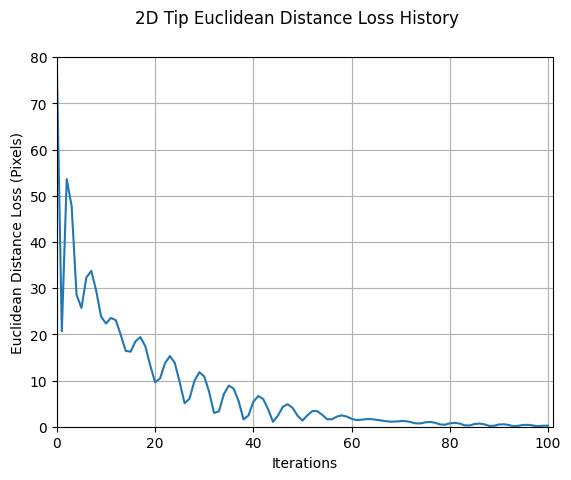

d3d_end_effector_loss_history:  [0.020112991333007812, 0.018926968798041344, 0.024179905652999878, 0.021900014951825142, 0.017402032390236855, 0.013764710165560246, 0.011580323800444603, 0.01005638763308525, 0.008575442247092724, 0.007459454704076052, 0.007212379481643438, 0.007313503418117762, 0.006944112945348024, 0.005897725000977516, 0.004579548258334398, 0.003849682630971074, 0.004095748066902161, 0.004581288900226355, 0.0047669787891209126, 0.004697693511843681, 0.004707373213022947, 0.005032827146351337, 0.005516332108527422, 0.00584040954709053, 0.005913936998695135, 0.005968526005744934, 0.006348878610879183, 0.00713213998824358, 0.008049932308495045, 0.008787567727267742, 0.009205779060721397, 0.009362786076962948, 0.00942525640130043, 0.009537078440189362, 0.009728399105370045, 0.009944217279553413, 0.010148383677005768, 0.010374135337769985, 0.010674238204956055, 0.01104110199958086, 0.011392246000468731, 0.011633731424808502, 0.011731673963367939, 0.01173114962875843, 0.01

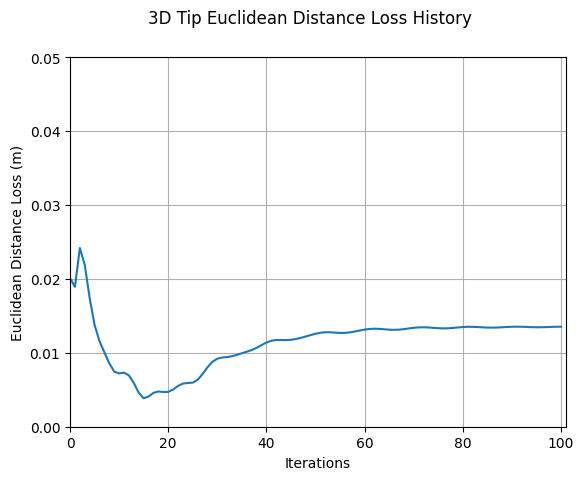

In [7]:

if __name__ == '__main__':
    '''
    Main function to set up optimzer model and run the optimization loop
    '''

    ###========================================================
    ### 1) SET TO GPU OR CPU COMPUTING
    ###========================================================
    if torch.cuda.is_available():
        gpu_or_cpu = torch.device("cuda:0") 
        torch.cuda.set_device(gpu_or_cpu)
    else:
        gpu_or_cpu = torch.device("cpu")

    ###========================================================
    ### 2) VARIABLES FOR BEZIER CURVE CONSTRUCTION
    ###========================================================
    # para_init = torch.tensor([0.02, 0.002, 0.0, 0.01958988, 0.00195899, 0.09690406, -0.03142905, -0.0031429, 0.18200866], dtype=torch.float)
    # p_start = torch.tensor([0.02, 0.002, 0.0])


    # Z axis + 0.1
    # para_init = torch.tensor([0.02, 0.002, 0.1, 0.01958988, 0.00195899, 0.09690406, -0.03142905, -0.0031429, 0.18200866], dtype=torch.float)
    # p_start = torch.tensor([0.02, 0.002, 0.1000])
        
    

    # p_start and para_init used for SRC presentation
    # ground truth: [ 0.02007997  0.00160014  0.1026283   0.02973628 -0.04668138  0.19240253]
    p_start = torch.tensor([0.02, 0.002, 0.000001]) # 0 here will cause NaN in draw2DCylinderImage, pTip
    # para_init = np.array([0.0365, 0.0036,  0.1202,  0.0056, -0.0166, 0.1645],
    #                  dtype=np.float32) # 0, converge
    para_init = np.array([0.03, 0.0055,  0.0702,  0.0206, -0.0306, 0.1845],
                     dtype=np.float32) # 1, converge
    # para_init = np.array([0.03, 0.0055,  0.0702,  0.0186, -0.0306, 0.1815],
    #                  dtype=np.float32) # 2, converge
    # para_init = np.array([0.03, 0.0055,  0.0702,  0.0186, -0.0266, 0.2115],
    #                  dtype=np.float32) # 3, diverge
    # para_init = np.array([0.03, 0.0055,  0.0702,  0.0226, -0.0506, 0.2115],
    #                  dtype=np.float32) # 4
    # para_init = np.array([0.03, 0.0055,  0.0802,  0.0226, -0.0406, 0.2115],
    #                  dtype=np.float32) # 5
    # para_init = np.array([0.0395, 0.0066,  0.1502,  0.0006, -0.0066, 0.1045],
    #                  dtype=np.float32)
    # para_init = np.array([0.0395, -0.0066,  0.1502,  0.0006, -0.0066, 0.1045],
    #                  dtype=np.float32)
    # para_init = np.array([0.04, -0.0166,  0.2002,  -0.0006, -0.0266, 0.0345],
    #                  dtype=np.float32)
    # para_init = np.array([0.02, 0.002,  0.1,  0.03, -0.05, 0.2],
    #                  dtype=np.float32)

    # case_naming = '/Users/kobeyang/Downloads/Programming/ECESRIP/diff_catheter/scripts/test_diff_render_catheter_v2/blender_imgs/test_catheter_gt1'
    # case_naming = 'E:/OneDrive - UC San Diego/UCSD/Lab/Catheter/diff_catheter/scripts/test_diff_render_catheter_v2/blender_imgs/test_catheter_gt1'
    case_naming = 'E:/OneDrive - UC San Diego/UCSD/Lab/Catheter/diff_catheter/data/rendered_images/dof2_64/dof2_c48_0.001_-0.005_0.2_0.01'
    img_save_path = case_naming + '.png'
    cc_specs_path = case_naming + '_gt.npy'
    target_specs_path = None
    viewpoint_mode = 1
    transparent_mode = 0

    '''
    Create binary mask of catheter: 
        1) Grayscale the ref img, 
        2) threshold the grayscaled img, 
        3) Creates a binary image by replacing all 
            pixel values equal to 255 with 1 (leaves
            other pixel values unchanged)
    '''
    # img_ref_rgb = cv2.imread(img_save_path)
    # img_ref_gray = cv2.cvtColor(img_ref_rgb, cv2.COLOR_BGR2GRAY)
    # (thresh, img_ref_thresh) = cv2.threshold(img_ref_gray, 80, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    # img_ref_binary = np.where(img_ref_thresh == 255, 1, img_ref_thresh)
    img_ref_binary = process_image(img_save_path)

    # Declare loss history lists to keep track of loss values
    proj_end_effector_loss_history = []
    d3d_end_effector_loss_history = []
    # Ground Truth parameters for catheter used in SRC presentation
    para_gt_np = np.load(cc_specs_path)[1:3, :].flatten()
    para_gt = torch.tensor(para_gt_np, dtype=torch.float, device=gpu_or_cpu, requires_grad=False)
    # para_gt = torch.tensor([0.02003904, 0.0016096, 0.13205799, 0.00489567, -0.03695673, 0.196168896], dtype=torch.float, device=gpu_or_cpu, requires_grad=False)
    end_effector_gt = para_gt[3:6]
    
    folder_path = 'E:/OneDrive - UC San Diego/UCSD/Lab/Catheter/diff_catheter/data/rendered_images/dof2_64/'
    image_save_path_list = [
    folder_path + 'dof2_c47_0.0005_0.005_0.2_0.01.png',
    folder_path + 'dof2_c46_0.0005_0.001_0.2_0.01.png',
    folder_path + 'dof2_c45_0.0005_0.0005_0.2_0.01.png',
    folder_path + 'dof2_c42_0.0005_-0.0005_0.2_0.01.png',
    folder_path + 'dof2_c40_0.0005_-0.005_0.2_0.01.png',
    folder_path + 'dof2_c39_0.0001_0.005_0.2_0.01.png',
    folder_path + 'dof2_c32_0.0001_-0.005_0.2_0.01.png',
    folder_path + 'dof2_c31_-0.0001_0.005_0.2_0.01.png',
    folder_path + 'dof2_c6_-0.005_0.001_0.2_0.01.png'
    ]
    
    past_frames_list = []
    for path in image_save_path_list:
        past_frames_list.append(process_image(path))
    
    delta_u_list = [[0.0005, -0.01], [0, 0.004], [0, 0.0005], [0, 0.001], [0, 0.0045], [0.0004, -0.01], [0, 0.01], [0.0002, -0.01], [0.0049, 0.004]]

    


    ###========================================================
    ### 3) SET UP AND RUN OPTIMIZATION MODEL
    ###========================================================
    catheter_optimize_model = ReconstructionOptimizer(p_start, para_init, img_ref_binary, gpu_or_cpu, past_frames_list, delta_u_list, img_save_path, image_save_path_list).to(gpu_or_cpu)

    print("Model Parameters:")
    for name, param in catheter_optimize_model.named_parameters():
        print(f"{name}: requires_grad={param.requires_grad}")

    optimizer = torch.optim.Adam(catheter_optimize_model.parameters(), lr=1e-2)

    # Run the optimization loop
    num_iterations = 100
    loop = tqdm(range(num_iterations))
    for loop_id in loop:
        print("\n================================================================================================================")
        print("loop_id: ", loop_id)


        # save_img_path = '/Users/kobeyang/Downloads/Programming/ECESRIP/diff_catheter/scripts/test_diff_render_catheter_v2/rendered_imgs/' \
        #     + 'render_' + str(loop_id) + '.jpg'
            
        save_img_path = 'E:/OneDrive - UC San Diego/UCSD/Lab/Catheter/diff_catheter/scripts/test_diff_render_catheter_v2/rendered_imgs_new/' \
            + 'render_' + str(loop_id) + '.jpg'

        # pdb.set_trace()

        # Zero the gradients before running the backward pass.
        optimizer.zero_grad()

        # Run the forward pass
        loss = catheter_optimize_model(save_img_path)

        # Print gradients for all parameters before backward pass
        print("Gradients BEFORE BACKWARD PASS:")
        for name, param in catheter_optimize_model.named_parameters():
            if param.grad is not None:
                print(f"Parameter: {name}, Gradient: {param.grad.norm().item()}")  # Print the norm of the gradient
            else:
                print(f"{name}: No gradient computed")

        # Run the backward pass
        loss.backward(retain_graph=True)

        # Print gradients for all parameters after backward pass
        print("Gradients AFTER BACKWARD PASS:")
        for name, param in catheter_optimize_model.named_parameters():
            if param.grad is not None:
                print(f"Parameter: {name}, Gradient: {param.grad.norm().item()}")
            else:
                print(f"{name}: No gradient computed")
                
        # end_effector_loss_history.append(torch.norm((catheter_optimize_model.para_init[3:6] - end_effector_gt), p=2).item())
        proj_end_effector_loss_history.append(catheter_optimize_model.tip_euclidean_distance_loss.item())
        d3d_end_effector_loss_history.append(torch.norm((catheter_optimize_model.para_init[3:6] - end_effector_gt), p=2).item())

        # Update the parameters
        optimizer.step()


        # Print and inspect the updated parameters
        for name, param in catheter_optimize_model.named_parameters():
            print(f"Parameter: {name}, Updated Value: {param.data}")


        # # end_effector_loss_history.append(torch.norm((catheter_optimize_model.para_init[3:6] - end_effector_gt), p=2).item())
        # proj_end_effector_loss_history.append(catheter_optimize_model.tip_euclidean_distance_loss.item())
        # d3d_end_effector_loss_history.append(torch.norm((catheter_optimize_model.para_init[3:6] - end_effector_gt), p=2).item())

        # Update the progress bar
        loop.set_description('Optimizing')

        # Update the loss
        loop.set_postfix(loss=loss.item())

        print("Loss: ", loss.item())

    # end_effector_loss_history.append(torch.norm((catheter_optimize_model.para_init[3:6] - end_effector_gt), p=2).item())
    proj_end_effector_loss_history.append(catheter_optimize_model.tip_euclidean_distance_loss.item())
    d3d_end_effector_loss_history.append(torch.norm((catheter_optimize_model.para_init[3:6] - end_effector_gt), p=2).item())

    for name, param in catheter_optimize_model.named_parameters():
        param_numpy = param.data.cpu().numpy()
        filename = f"{name}.npy"
        np.save(filename, param_numpy)
        print(f"Saved {name} to {filename}")

    # Given array of values proj_end_effector_loss_history, create plot of loss vs. iterations
    iterations_x_axis_proj = list(range(len(proj_end_effector_loss_history)))
    print("proj_end_effector_loss_history: ", proj_end_effector_loss_history)
    fig1 = plt.figure()
    ax1 = fig1.add_subplot(111)
    fig1.suptitle('2D Tip Euclidean Distance Loss History')
    ax1.plot(iterations_x_axis_proj, proj_end_effector_loss_history)
    ax1.set_xlabel('Iterations')
    ax1.set_ylabel('Euclidean Distance Loss (Pixels)')
    ax1.set_xlim([0, len(proj_end_effector_loss_history)])
    ax1.set_ylim([0, 80])
    ax1.grid(True)
    plt.show()


    # Given array of values d3d_end_effector_loss_history, create plot of 3d loss vs. iterations
    iterations_x_axis_3d = list(range(len(d3d_end_effector_loss_history)))
    print("d3d_end_effector_loss_history: ", d3d_end_effector_loss_history)
    fig2 = plt.figure()
    ax2 = fig2.add_subplot(111)
    fig2.suptitle('3D Tip Euclidean Distance Loss History')
    ax2.plot(iterations_x_axis_3d, d3d_end_effector_loss_history)
    ax2.set_xlabel('Iterations')
    ax2.set_ylabel('Euclidean Distance Loss (m)')
    ax2.set_xlim([0, len(d3d_end_effector_loss_history)])
    ax2.set_ylim([0, 0.05])
    ax2.grid(True)
    plt.show()

proj_end_effector_loss_history:  [77.2180606256328, 20.693518729040246, 53.58400418945786, 47.736187532707184, 28.539912773198946, 25.713971205831953, 32.286041008202815, 33.73868610775619, 29.44212554417102, 23.845483181783855, 22.32634128055884, 23.551482553470183, 23.048977449115466, 19.895727054405853, 16.429330833267738, 16.242327298570594, 18.48912846000545, 19.39438774622417, 17.433978496049015, 13.286117216183778, 9.62924291884599, 10.438193888967689, 13.71384174004473, 15.307927782223734, 13.817382835546644, 9.660615672749149, 5.074241144399822, 6.06601904009371, 9.899219479287643, 11.794447303353921, 10.887152293304158, 7.530810783569682, 2.9757770818139546, 3.340229495716624, 7.056146958764782, 8.883737232226702, 8.267292496675024, 5.533758096317632, 1.5843285080750402, 2.423310816614716, 5.403736035734284, 6.650034787717356, 5.989270688636812, 3.796813892092691, 1.0689222872770432, 2.3866899728561144, 4.29997583200689, 4.870384618536397, 4.0659976708290095, 2.38479737210777

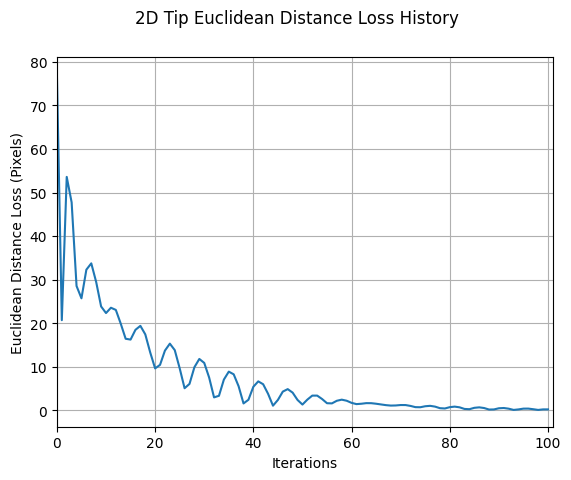

d3d_end_effector_loss_history:  [0.020112991333007812, 0.018926968798041344, 0.024179905652999878, 0.021900014951825142, 0.017402032390236855, 0.013764710165560246, 0.011580323800444603, 0.01005638763308525, 0.008575442247092724, 0.007459454704076052, 0.007212379481643438, 0.007313503418117762, 0.006944112945348024, 0.005897725000977516, 0.004579548258334398, 0.003849682630971074, 0.004095748066902161, 0.004581288900226355, 0.0047669787891209126, 0.004697693511843681, 0.004707373213022947, 0.005032827146351337, 0.005516332108527422, 0.00584040954709053, 0.005913936998695135, 0.005968526005744934, 0.006348878610879183, 0.00713213998824358, 0.008049932308495045, 0.008787567727267742, 0.009205779060721397, 0.009362786076962948, 0.00942525640130043, 0.009537078440189362, 0.009728399105370045, 0.009944217279553413, 0.010148383677005768, 0.010374135337769985, 0.010674238204956055, 0.01104110199958086, 0.011392246000468731, 0.011633731424808502, 0.011731673963367939, 0.01173114962875843, 0.01

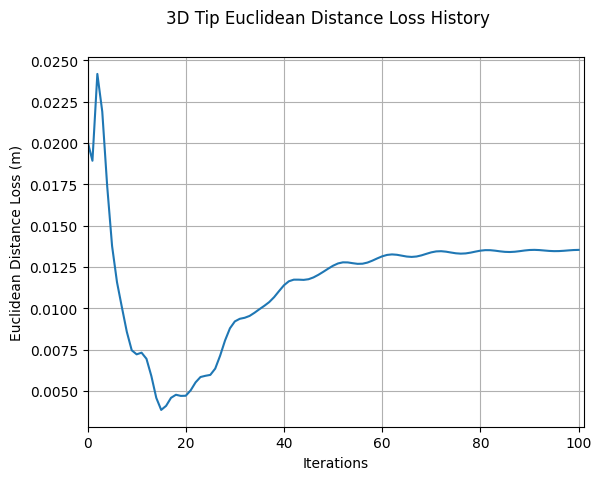

In [8]:
# Given array of values proj_end_effector_loss_history, create plot of loss vs. iterations
iterations_x_axis_proj = list(range(len(proj_end_effector_loss_history)))
print("proj_end_effector_loss_history: ", proj_end_effector_loss_history)
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
fig1.suptitle('2D Tip Euclidean Distance Loss History')
ax1.plot(iterations_x_axis_proj, proj_end_effector_loss_history)
ax1.set_xlabel('Iterations')
ax1.set_ylabel('Euclidean Distance Loss (Pixels)')
ax1.set_xlim([0, len(proj_end_effector_loss_history)])
# ax1.set_ylim([0, 80])
ax1.grid(True)
plt.show()


# Given array of values d3d_end_effector_loss_history, create plot of 3d loss vs. iterations
iterations_x_axis_3d = list(range(len(d3d_end_effector_loss_history)))
print("d3d_end_effector_loss_history: ", d3d_end_effector_loss_history)
fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
fig2.suptitle('3D Tip Euclidean Distance Loss History')
ax2.plot(iterations_x_axis_3d, d3d_end_effector_loss_history)
ax2.set_xlabel('Iterations')
ax2.set_ylabel('Euclidean Distance Loss (m)')
ax2.set_xlim([0, len(d3d_end_effector_loss_history)])
# ax2.set_ylim([0, 0.05])
ax2.grid(True)
plt.show()